# Primer ejemplo para hacer un notebook python
## Empezamos por hacer nuestro shell
Creamos nuestro Shell FCC de 10 capas, distancia interatómica de 2.49 Angstroms y hacemos un radcut de 15 A, y de igual manera lo visualizamos con jmol

In [1]:
from sys import path
import os
dir_actual = os.getcwd()
path.insert(0, 'C:/Users/guill/OneDrive/Documentos/Tesis/Proyect')

import myfuncions.core_shell_f as cs
import myfuncions.tools_f as tools
import subprocess as sbp

coords = cs.cubeShell(12,2.49,'fcc')
coords = cs.sphericalShave(coords,15)
atpos, eleList = cs.atpos_eleList_maker(coords,'Ni')
tools.show_percent(atpos,eleList)

name='Ni-FCC.xyz'
tools.wXYZ(atpos,name)

sbp.run(['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', name])

atomos totales : 1289
Ni : 100.0 %, 1289


CompletedProcess(args=['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', 'Ni-FCC.xyz'], returncode=0)

Aquí lo obtenido:

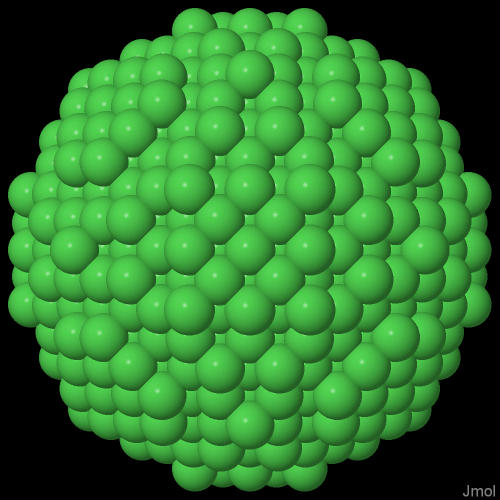

Trabajamos con lammpin

In [2]:
from myfuncions.lammpin_f import wlammpin
wlammpin(atpos,eleList,name)

Ni-FCC.ini


## Dinámica Molecular empieza aquí
Hacemos 600 pasos de rescale a 0K, 3000 pasos de rampa hacia 300K con berendsen y 3000 pasos de termalización con langevin a 300K

In [4]:

input = f"""
# 2NN EAM potential in LAMMPS

 units		metal
 atom_style	atomic
 boundary	f f f

 read_data	{name[:-4]}.ini
 pair_style	meam
 pair_coeff	* * ..\\..\\LAMMPS\\library.meam Pt Ni ..\\..\\LAMMPS\\PtNiV2.pot Pt Ni 
 
 neighbor	0.5 bin
 neigh_modify	every 1 delay 0 check yes once no
 velocity	all create 0.00 13478 rot yes mom yes dist gaussian
 timestep	0.005

 fix            1 all nve
 fix            2 all temp/rescale 10 0.00 0.00 1.0 1
 thermo         100
 thermo_style   custom step temp atoms pe ke etotal
 thermo_modify  lost ignore
 run 600

 unfix 2
 fix         3 all temp/berendsen 0.0 300.0 0.1
 thermo		100
 run		3000

 unfix 3
 timestep   0.001
 thermo		100
 fix		4 all langevin 300.0 300.0 0.5 87654
 dump       4 all xyz 1 dump_temp.xyz
 undump     4
 run        1
 dump       4 all xyz 599 {name[:-4]}_d.xyz
 run		599
"""
with open('input.in','w') as archivo:
    archivo.write(input)

os.system('start powershell -Command lmp -in input.in; Start-Sleep -s 20; exit')

0

## Análisis del dump
Se hace el análisis mostrado la distribución radial y fracción de atomos por radio

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


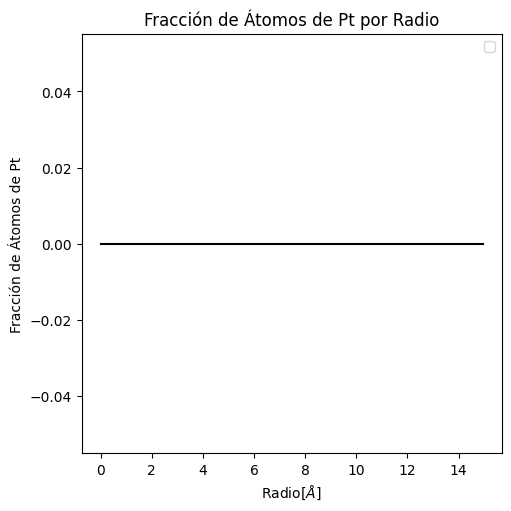

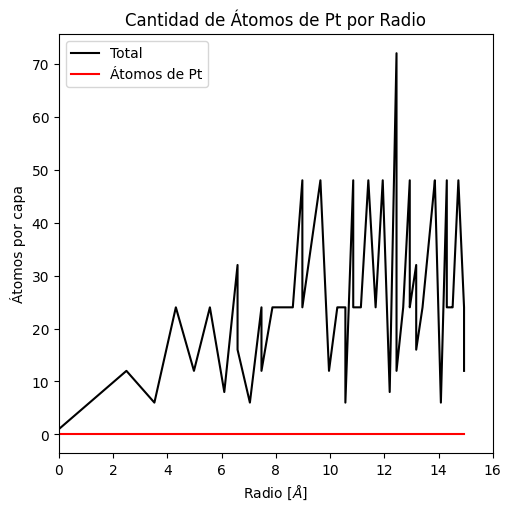

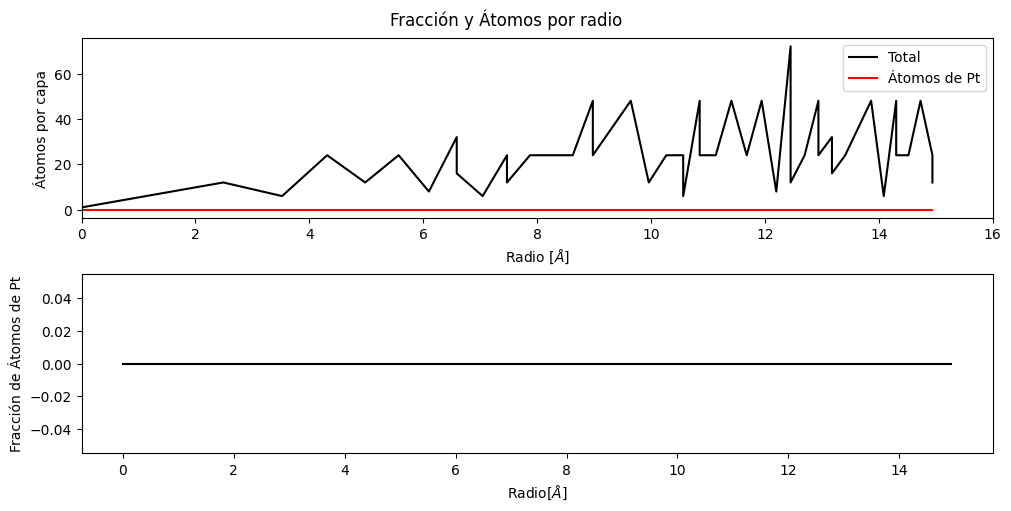

In [5]:
import myfuncions.graphs_f as plt


gatpos, geleList = plt.leer_xyz(f'{name[:-4]}.xyz')
plt.graficar_fracc_at_p_rad(gatpos,'Pt')
plt.graficar_at_p_rad(gatpos,'Pt')
plt.plot_fracc_y_at_p_rad(gatpos,'Pt')

### A trabajar con el dump
ahora estaremos trabajando con el dump, cambiando etiquetas y mostrandolo de nuevo

In [6]:
import myfuncions.tools_f as tools

dumpatpos, dumpeleList = tools.leer_xyz(f'{name[:-4]}_d.xyz')
dumpatpos, dumpeleList = tools.cambiar_etiquetas_xyz(dumpatpos,dumpeleList,{1: 'Ni', 2: 'Pt'})
tools.wXYZ(dumpatpos,f'{name[:-4]}_d.xyz')

sbp.run(['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', f'{name[:-4]}_d.xyz'])

Cambia etiquetas a "atpos"
jala


CompletedProcess(args=['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', 'Ni-FCC_d.xyz'], returncode=0)

Este es el dump: Se ve que no pierde mucha estructura respecto al original

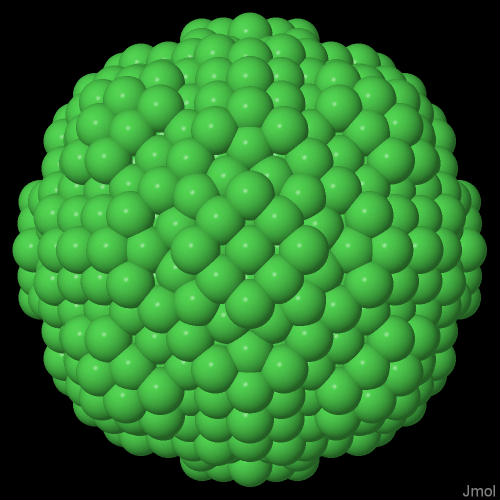

## Aquí se hace el PDF y la gráfica


In [7]:
import PDF.runner as pdf
pdf.run_pdf(f'{name[:-4]}_d.xyz', dir_actual, 1600,0.02)

c:\Users\guill\OneDrive\Documentos\Tesis\Proyect\15_de_marzo\Ni_100

  -3.68058991      -3.59528995      -13.3302002              28   36092.0000    
   1.46000006E-03  -2.68262005      -14.5636997              28   36092.0000    
   3.47823000      -3.48974991      -13.0072002              28   36092.0000    
        1289  atomos       830116  pares 
 Rango de distancias    2.10143805     -   30.2648716    
 Distancias promedio    15.5047016    
 Factor de normalizacion    65387.7695    



Hacemos la gráfica PDF, Nota: Este PDF se puede ver que si tiene forma de FCC

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


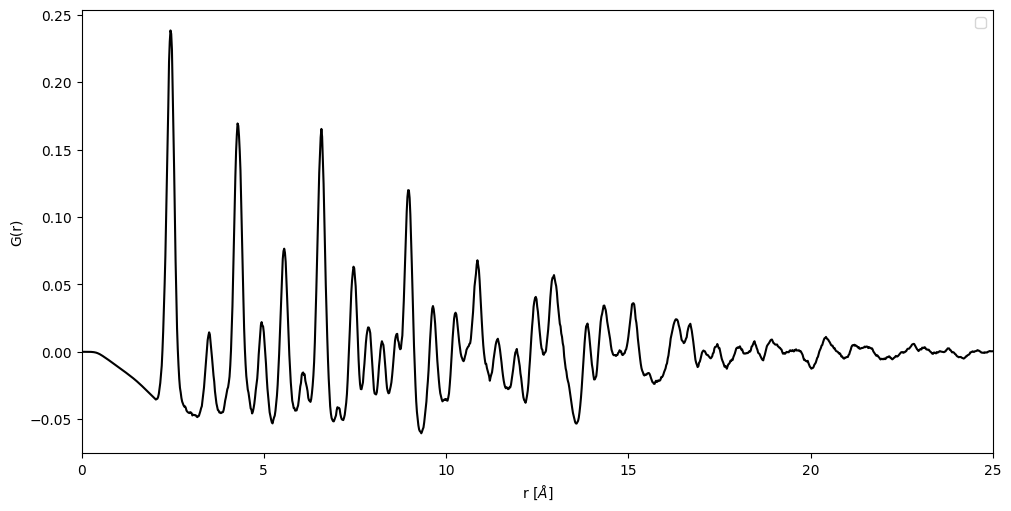

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


df_FCC= pd.read_csv(f'{name[:-4]}_d.txt', sep='\s+')

fig, ax =plt.subplots(figsize=(10,5), layout='constrained')
ax.plot(df_FCC['#r(A)'], df_FCC['G(r)'], color = 'black')


ax.set_xlabel('r [$\\AA$]')
ax.set_xlim([0,25])
ax.set_ylabel('G(r)')
#ax.set_title('PDF para nanopartícula de 3nm de Ni')
#ax.grid('True', linestyle='-')
ax.legend()
plt.show()